In [20]:
import pandas as pd
import numpy as np
%matplotlib inline

# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# для игнорирования предупреждений (опционально)
# import warnings
# warnings.filterwarnings("ignore")


1. Сбор данных

In [21]:
# загружаем dataset, который содержит данные о новой вирусной инекции COVID-2019 в разрезе стран
# устанавливаем индексную колонку 
df = pd.read_csv('./owid-covid-data.csv', index_col=['date'], parse_dates = ['date'], dayfirst=True)
df.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,5.0,5.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-25,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-26,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-27,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2020-02-28,AFG,Asia,Afghanistan,5.0,0.0,NaN,NaN,NaN,NaN,0.126,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [22]:
# смотрим данные каких стран есть в датасете
loca=df.location.value_counts().index
for idx in loca:
    print(idx) 

Argentina
Mexico
Peru
Thailand
Taiwan
South Korea
Lower middle income
Upper middle income
Japan
China
Asia
United States
World
North America
High income
Singapore
Europe
Hong Kong
Vietnam
European Union
Malaysia
France
Nepal
Oceania
Australia
Canada
Germany
Sri Lanka
Cambodia
Finland
Spain
United Arab Emirates
India
Philippines
Fiji
United Kingdom
Russia
Italy
Sweden
Denmark
Slovenia
Estonia
Belgium
South Africa
Morocco
International
Africa
Egypt
Guatemala
Greece
Portugal
Iran
Israel
Lebanon
South America
Latvia
Chile
Czechia
Low income
Bahrain
Iraq
Oman
Afghanistan
Kuwait
Luxembourg
Switzerland
Austria
Pakistan
Croatia
Algeria
Albania
Serbia
North Macedonia
Iceland
Brazil
Romania
Norway
Georgia
Netherlands
Senegal
Belarus
Nigeria
New Zealand
Lithuania
Qatar
San Marino
Monaco
Ireland
Dominican Republic
Azerbaijan
Ecuador
Armenia
Andorra
Saudi Arabia
Indonesia
Jordan
Bangladesh
Ukraine
Hungary
Libya
Tunisia
Togo
Poland
Liechtenstein
Malta
Bosnia and Herzegovina
Palestine
Colombia
Costa 

In [23]:
#выбираем страну Турция, проанализируем данные о случаях заболеваемости в данной стране
df1=df[df.location=='Turkey']
df1.head(50)

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-03-11,TUR,Asia,Turkey,1.0,1.0,NaN,NaN,NaN,NaN,0.012,...,14.1,41.1,NaN,2.81,77.69,0.82,NaN,NaN,NaN,NaN
2020-03-12,TUR,Asia,Turkey,1.0,0.0,NaN,NaN,NaN,NaN,0.012,...,14.1,41.1,NaN,2.81,77.69,0.82,NaN,NaN,NaN,NaN
2020-03-13,TUR,Asia,Turkey,5.0,4.0,NaN,NaN,NaN,NaN,0.059,...,14.1,41.1,NaN,2.81,77.69,0.82,NaN,NaN,NaN,NaN
2020-03-14,TUR,Asia,Turkey,5.0,0.0,NaN,NaN,NaN,NaN,0.059,...,14.1,41.1,NaN,2.81,77.69,0.82,NaN,NaN,NaN,NaN
2020-03-15,TUR,Asia,Turkey,6.0,1.0,NaN,NaN,NaN,NaN,0.071,...,14.1,41.1,NaN,2.81,77.69,0.82,NaN,NaN,NaN,NaN
2020-03-16,TUR,Asia,Turkey,18.0,12.0,2.571,NaN,NaN,0.000,0.212,...,14.1,41.1,NaN,2.81,77.69,0.82,NaN,NaN,NaN,NaN
2020-03-17,TUR,Asia,Turkey,47.0,29.0,6.714,1.0,1.0,0.143,0.553,...,14.1,41.1,NaN,2.81,77.69,0.82,NaN,NaN,NaN,NaN
2020-03-18,TUR,Asia,Turkey,98.0,51.0,13.857,1.0,0.0,0.143,1.152,...,14.1,41.1,NaN,2.81,77.69,0.82,NaN,NaN,NaN,NaN
2020-03-19,TUR,Asia,Turkey,192.0,94.0,27.286,3.0,2.0,0.429,2.258,...,14.1,41.1,NaN,2.81,77.69,0.82,NaN,NaN,NaN,NaN


2. Разведочный анализ

In [24]:
# проверим сколько записей в датасете и есть ли пропуски
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 631 entries, 2020-03-11 to 2021-12-01
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    631 non-null    object 
 1   continent                                   631 non-null    object 
 2   location                                    631 non-null    object 
 3   total_cases                                 631 non-null    float64
 4   new_cases                                   630 non-null    float64
 5   new_cases_smoothed                          626 non-null    float64
 6   total_deaths                                625 non-null    float64
 7   new_deaths                                  625 non-null    float64
 8   new_deaths_smoothed                         626 non-null    float64
 9   total_cases_per_million                     631 non-null    float64


In [ ]:
# видим, что в некоторых столбцах есть пропущенные значения
# для анализа используем столбец 'total_cases' - 'Всего подтвержденных случаев COVID-19', пропущенных значений в данном столбце нет

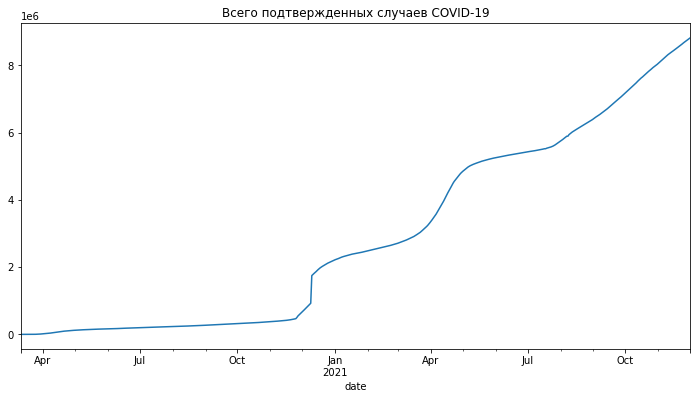

In [62]:
# строим график нашего временного ряда, с помощью функции plot()
title = 'Всего подтвержденных случаев COVID-19'
df1['total_cases'].plot(figsize=(12,6),title=title).autoscale(axis='x',tight=True)


In [ ]:
# из графика видно, что временной ряд не имеет ярко выраженных выбросов, но прослеживается тренд и сезонность, 
# делаем вывод, что ряд не стационарен

In [27]:
#перейдем к недельному интервалу и среднему значению, чтобы уменьшить колебания ряда с помощью функции rolling
df2= df1['total_cases'].rolling(window=7).mean()
df2

date
2020-03-11             NaN
2020-03-12             NaN
2020-03-13             NaN
2020-03-14             NaN
2020-03-15             NaN
                  ...     
2021-11-27    8.651455e+06
2021-11-28    8.676384e+06
2021-11-29    8.701236e+06
2021-11-30    8.725665e+06
2021-12-01    8.749376e+06
Name: total_cases, Length: 631, dtype: float64

In [30]:
# заполним пропуски нулями
df3=df2.fillna(0.0)
df3

date
2020-03-11    0.000000e+00
2020-03-12    0.000000e+00
2020-03-13    0.000000e+00
2020-03-14    0.000000e+00
2020-03-15    0.000000e+00
                  ...     
2021-11-27    8.651455e+06
2021-11-28    8.676384e+06
2021-11-29    8.701236e+06
2021-11-30    8.725665e+06
2021-12-01    8.749376e+06
Name: total_cases, Length: 631, dtype: float64

<AxesSubplot:xlabel='date'>

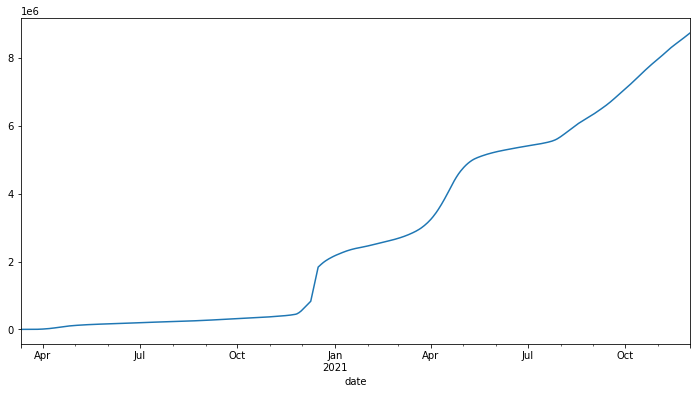

In [32]:
# снова строим график временного ряда, он стал более сглаженным 
df3.plot(figsize=(12,6))

<AxesSubplot:>

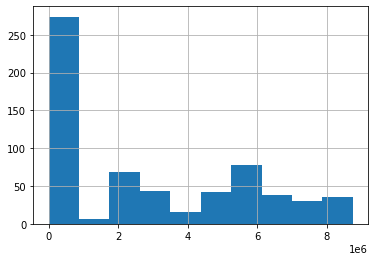

In [33]:
#построим гистограмму, видим, что вначале есть явный выброс, дальше данные более однородные
df3.hist()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

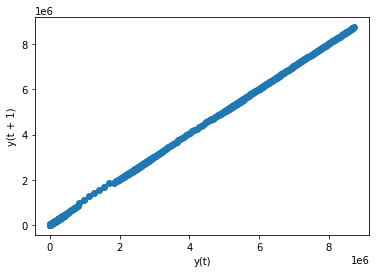

In [63]:
# сторим график корреляции, видим что данные зависимы друг от друга, прослеживается явная зависимость 
from pandas.plotting import lag_plot
lag_plot(df3)

3. Выбор и настройка модели

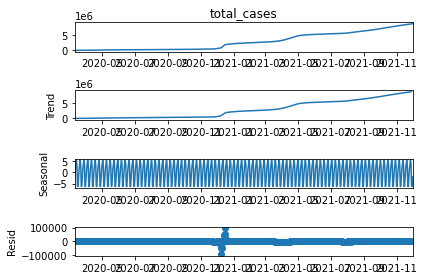

In [34]:
# выполним ETS декомпозицию, разложим временной ряд на составляющие тренда, сезонности и ошибки
result = seasonal_decompose(df3, model='add')
result.plot();

In [ ]:
# из графика видим, что есть тренд, сезонная составляющая и небольшой шум

In [69]:
# запускаем pmdarima.auto_arima для построения модели оптимальных значений при m=7 (сезонная составляющая)
auto_arima(df3, seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  631
Model:             SARIMAX(0, 2, 0)x(2, 0, 0, 7)   Log Likelihood               -6300.611
Date:                           Wed, 22 Dec 2021   AIC                          12607.222
Time:                                   13:00:33   BIC                          12620.555
Sample:                                        0   HQIC                         12612.401
                                           - 631                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.6140      0.005   -119.006      0.000      -0.624      -0.604
ar.S.L14      -0.2742      0.006    -46.002      0.000      -0.286      -0.262
sigma2      2.993e+07   6.11e-12    4.9e+18      0.000    2.99e+07    2.99e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.13   Jarque-Bera (JB):           2749820.35
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):              70.10   Skew:                            12.92
Prob(H) (two-sided):                  0.00   Kurtosis:                       325.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# модель получилась SARIMAX(0, 2, 0)x(2, 0, 0, 7)

In [70]:
# определим размер датасета
len(df3)

631

In [71]:
# обучим модель на тренировочном множестве, а затем проверим ее на тестовом, для этого разделим датасет на train и test
train = df3.iloc[:504]
test = df3.iloc[504:]


In [72]:
# установим частоту в днях
df3.index.freq = 'D'

Обучаем SARIMA(0, 2, 0)(2, 0, 0, 7)

In [73]:
model = SARIMAX(train, order=(0, 2, 0), seasonal_order=(2, 0, 0, 7) )
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       total_cases   No. Observations:                  504
Model:             SARIMAX(0, 2, 0)x(2, 0, 0, 7)   Log Likelihood               -5084.185
Date:                           Wed, 22 Dec 2021   AIC                          10174.371
Time:                                   13:08:59   BIC                          10187.027
Sample:                               03-11-2020   HQIC                         10179.336
                                    - 07-27-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.6144      0.006    -94.866      0.000      -0.627      -0.602
ar.S.L14      -0.2740      0.007    -36.638      0.000      -0.289      -0.259
sigma2      3.755e+07   6.05e-12   6.21e+18      0.000    3.75e+07    3.75e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.36   Jarque-Bera (JB):           1421676.38
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):             134.76   Skew:                            11.64
Prob(H) (two-sided):                  0.00   Kurtosis:                       262.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.74e+34. Standard errors may be unstable.
"""

In [74]:
# определяем предсказанные значения
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0, 2, 0)x(2, 0, 0, 7) ')

In [75]:
# Сравниваем результаты
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test[i]}")

predicted=5604223.87 , expected=5606421.428571428
predicted=5616907.113, expected=5623382.428571428
predicted=5629174.988, expected=5641913.285714285
predicted=5640945.432, expected=5661865.714285715
predicted=5651672.822, expected=5682769.571428572
predicted=5661882.748, expected=5704543.285714285
predicted=5671031.232, expected=5727041.428571428
predicted=5680240.117, expected=5750186.857142857
predicted=5689534.034, expected=5773637.428571428
predicted=5698919.709, expected=5797355.714285715
predicted=5708426.464, expected=5821469.428571428
predicted=5718017.129, expected=5842598.857142857
predicted=5727868.496, expected=5867085.714285715
predicted=5737942.229, expected=5891824.714285715
predicted=5748027.495, expected=5916640.0
predicted=5758138.262, expected=5941164.428571428
predicted=5768306.45 , expected=5965319.571428572
predicted=5778536.526, expected=5988738.857142857
predicted=5789000.807, expected=6014850.571428572
predicted=5799446.682, expected=6036928.428571428
predicte

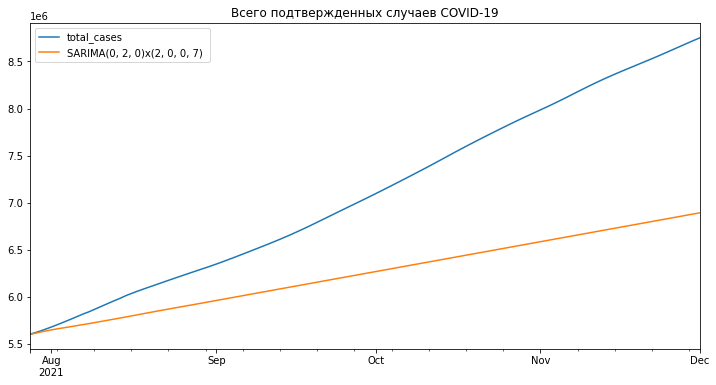

In [76]:
# для наглядности полученных результатов строим графики
title = 'Всего подтвержденных случаев COVID-19'
ylabel=''
xlabel=''

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [ ]:
# видим, что модель обучилась хорошо

4. Оценка модели прогноза 

In [77]:
# Оценка полученной модели
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'SARIMA(0, 2, 0)x(2, 0, 0, 7) MSE Error: {error:11.10}')

SARIMA(0, 2, 0)x(2, 0, 0, 7) MSE Error: 1.064290621e+12


In [78]:
from statsmodels.tools.eval_measures import rmse
# rmse = root mse
error = rmse(test, predictions)
print(f'SARIMA(0, 2, 0)x(2, 0, 0, 7) RMSE Error: {error:11.10}')

SARIMA(0, 2, 0)x(2, 0, 0, 7) RMSE Error:  1031644.62


In [79]:
df3.index.freq = 'D'

In [ ]:
# обучаем модель на полных данных и прогнозируем будущее

In [80]:
# (0, 2, 0)x(2, 0, 0, 7)
model = SARIMAX(df3,order=(0, 2, 0),seasonal_order=(2, 0, 0, 7))
results = model.fit()

fcast = results.predict(len(df3),len(df3)+123,typ='levels').rename('SARIMA(0, 2, 0)x(2, 0, 0, 7) Forecast')

In [ ]:
# для наглядности строим графики нашего временного ряда и обученной модели

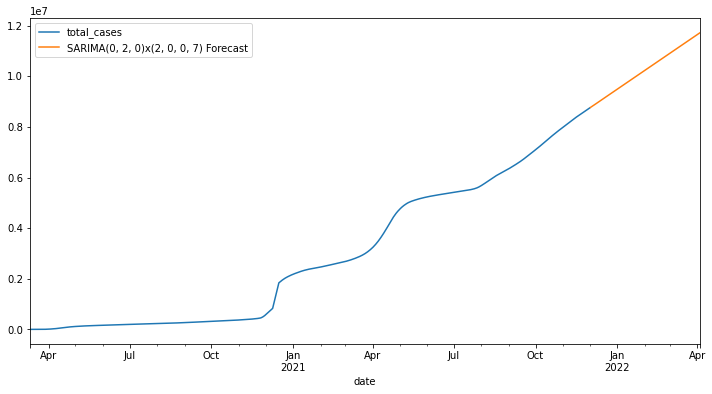

In [81]:
ax = df3.plot(legend=True,figsize=(12,6))
fcast.plot(legend=True);

In [ ]:
# из графика видим, что полученная модель продолжила наш график, это значит, что со временем число заболевших будет расти.